# Green Space Detection Method Comparison

Visual comparison of three methods:
1. **Green Filter** - NDVI threshold-based classification
2. **Random Forest** - ML-based classification
3. **OSM Ground Truth** - OpenStreetMap labels

In [15]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from green_filter import GreenSpaceFilter

%matplotlib inline

## Configuration

Change the city name here to compare different cities.

In [16]:
CITY = "London"

print(f"Comparing methods for: {CITY}")

Comparing methods for: London


## Load Data

In [17]:
# Paths
stack_path = f"processed_stacks/{CITY}_MultiMonth_stack.tif"
osm_labels_path = f"sentinel_data/{CITY}/{CITY}_OSM_labels.tif"

# Load stack
with rasterio.open(stack_path) as src:
    stack = src.read()
    profile = src.profile

print(f"Loaded stack: {stack.shape}")

# Load OSM ground truth
with rasterio.open(osm_labels_path) as src:
    osm_labels = src.read(1)

print(f"Loaded OSM labels: {osm_labels.shape}")

# Find a region with green pixels
aoi_size = 512
green_coords = np.argwhere(osm_labels == 1)

if len(green_coords) > 0:
    # Find center of green pixels
    center_y = int(np.median(green_coords[:, 0]))
    center_x = int(np.median(green_coords[:, 1]))
    print(f"Found green pixels, centering on: ({center_y}, {center_x})")
else:
    # Fallback to image center
    h, w = stack.shape[1], stack.shape[2]
    center_y, center_x = h // 2, w // 2
    print(f"No green pixels found, using image center: ({center_y}, {center_x})")

# Calculate AOI bounds
y_start = max(0, center_y - aoi_size // 2)
y_end = min(stack.shape[1], center_y + aoi_size // 2)
x_start = max(0, center_x - aoi_size // 2)
x_end = min(stack.shape[2], center_x + aoi_size // 2)

# Adjust if near edges
if y_end - y_start < aoi_size:
    if y_start == 0:
        y_end = min(stack.shape[1], aoi_size)
    else:
        y_start = max(0, stack.shape[1] - aoi_size)
        
if x_end - x_start < aoi_size:
    if x_start == 0:
        x_end = min(stack.shape[2], aoi_size)
    else:
        x_start = max(0, stack.shape[2] - aoi_size)

# Crop all data to AOI
stack = stack[:, y_start:y_end, x_start:x_end]
osm_labels = osm_labels[y_start:y_end, x_start:x_end]

print(f"Cropped to AOI: {stack.shape}")
print(f"AOI bounds: y=[{y_start}:{y_end}], x=[{x_start}:{x_end}]")
print(f"Green pixels in AOI: {np.sum(osm_labels==1):,} ({100*np.mean(osm_labels):.2f}%)")

# Create RGB composite (August bands: B04, B03, B02)
rgb = stack[[6, 5, 4], :, :].transpose(1, 2, 0)
rgb_norm = np.clip(rgb / 3000, 0, 1)

print("✓ Data loaded and cropped to AOI with green space")

Loaded stack: (12, 10980, 10980)
Loaded OSM labels: (10980, 10980)
Found green pixels, centering on: (9003, 9779)
Cropped to AOI: (12, 512, 512)
AOI bounds: y=[8747:9259], x=[9523:10035]
Green pixels in AOI: 45,569 (17.38%)
✓ Data loaded and cropped to AOI with green space


## Generate Green Filter Result

In [18]:
print("Generating Green Filter result...")

# Calculate NDVI manually for 12-band stack (4 bands × 3 months)
# Band order: B02, B03, B04, B08 for April (0-3), August (4-7), November (8-11)
def calculate_ndvi(nir, red):
    """Calculate NDVI from NIR and Red bands."""
    nir = nir.astype(float)
    red = red.astype(float)
    ndvi = (nir - red) / (nir + red + 1e-8)
    return ndvi

# Extract NDVI for each month
ndvi_april = calculate_ndvi(stack[3], stack[2])      # B08, B04
ndvi_august = calculate_ndvi(stack[7], stack[6])     # B08, B04
ndvi_november = calculate_ndvi(stack[11], stack[10]) # B08, B04

ndvi_maps = {
    'April': ndvi_april,
    'August': ndvi_august,
    'November': ndvi_november
}

# Multi-temporal classification (average NDVI across all months)
ndvi_mean = np.nanmean(np.stack([ndvi_april, ndvi_august, ndvi_november]), axis=0)

# Lower threshold to match WorldCover better (was 0.4, now 0.2)
NDVI_THRESHOLD = 0.2
green_filter_map = (ndvi_mean > NDVI_THRESHOLD).astype(np.uint8)

print(f"Green Filter NDVI threshold: {NDVI_THRESHOLD}")
print(f"Green Filter: {np.sum(green_filter_map==1):,} green pixels ({100*np.mean(green_filter_map):.2f}%)")
print(f"NDVI range: {np.nanmin(ndvi_mean):.3f} to {np.nanmax(ndvi_mean):.3f}")

Generating Green Filter result...
Green Filter NDVI threshold: 0.2
Green Filter: 73,326 green pixels (27.97%)
NDVI range: -0.309 to 0.644


## Load Random Forest Result

In [24]:
rf_prediction = None
results_dir = Path("results")

if results_dir.exists():
    city_results = sorted(results_dir.glob(f"{CITY}_*/prediction_map.tif"))
    if city_results:
        with rasterio.open(city_results[-1]) as src:
            rf_full = src.read(1)
            rf_profile = src.profile
        
        print(f"✓ Loaded Random Forest result: {city_results[-1]}")
        print(f"  RF prediction shape: {rf_full.shape}")
        print(f"  OSM labels shape: {osm_labels.shape}")
        
        # Check if RF was trained on AOI or full image
        if rf_full.shape == osm_labels.shape:
            # RF was trained on AOI - use directly (exact match)
            rf_prediction = rf_full
            print(f"  Using AOI-trained RF prediction directly (exact match)")
        elif abs(rf_full.shape[0] - osm_labels.shape[0]) <= 5 and abs(rf_full.shape[1] - osm_labels.shape[1]) <= 5:
            # RF shape is close to OSM shape (within 5 pixels) - likely AOI-trained with slight alignment difference
            # Resize to match exactly
            from scipy.ndimage import zoom
            scale_y = osm_labels.shape[0] / rf_full.shape[0]
            scale_x = osm_labels.shape[1] / rf_full.shape[1]
            rf_prediction = zoom(rf_full, (scale_y, scale_x), order=0).astype(np.uint8)  # order=0 = nearest neighbor
            print(f"  Resized AOI-trained RF from {rf_full.shape} to {rf_prediction.shape}")
        elif rf_full.shape[0] > 5000 and rf_full.shape[1] > 5000:
            # RF was trained on full image - crop to same AOI
            rf_prediction = rf_full[y_start:y_end, x_start:x_end]
            print(f"  Cropped full-image RF to AOI: {rf_prediction.shape}")
        else:
            print(f"  ⚠ RF shape mismatch - cannot align with current AOI")
            rf_prediction = None
        
        if rf_prediction is not None and rf_prediction.size > 0:
            print(f"Random Forest: {np.sum(rf_prediction==1):,} green pixels ({100*np.mean(rf_prediction):.2f}%)")
    else:
        print("⚠ No Random Forest results found. Run the training cell first.")
else:
    print("⚠ No results directory found.")

✓ Loaded Random Forest result: results/London_20260111_143043/prediction_map.tif
  RF prediction shape: (513, 513)
  OSM labels shape: (512, 512)
  Resized AOI-trained RF from (513, 513) to (512, 512)
Random Forest: 47,036 green pixels (17.98%)


## Calculate Metrics

In [25]:
def calculate_metrics(pred, truth):
    """Calculate accuracy metrics."""
    if pred is None:
        return None

    pred_bool = pred.astype(bool)
    truth_bool = truth.astype(bool)

    tp = np.sum(pred_bool & truth_bool)
    fp = np.sum(pred_bool & ~truth_bool)
    tn = np.sum(~pred_bool & ~truth_bool)
    fn = np.sum(~pred_bool & truth_bool)

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    green_pct = 100 * np.sum(pred_bool) / pred_bool.size

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'green_pct': green_pct,
        'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn
    }

# Calculate metrics
osm_metrics = calculate_metrics(osm_labels, osm_labels)
gf_metrics = calculate_metrics(green_filter_map, osm_labels)
rf_metrics = calculate_metrics(rf_prediction, osm_labels) if rf_prediction is not None else None

print("\n" + "="*60)
print("METRICS SUMMARY")
print("="*60)

print(f"\nOSM Ground Truth:")
print(f"  Green coverage: {osm_metrics['green_pct']:.2f}%")

print(f"\nGreen Filter (NDVI Threshold):")
print(f"  Green coverage: {gf_metrics['green_pct']:.2f}%")
print(f"  Accuracy:  {gf_metrics['accuracy']:.3f}")
print(f"  Precision: {gf_metrics['precision']:.3f}")
print(f"  Recall:    {gf_metrics['recall']:.3f}")
print(f"  F1 Score:  {gf_metrics['f1']:.3f}")

if rf_metrics:
    print(f"\nRandom Forest (ML):")
    print(f"  Green coverage: {rf_metrics['green_pct']:.2f}%")
    print(f"  Accuracy:  {rf_metrics['accuracy']:.3f}")
    print(f"  Precision: {rf_metrics['precision']:.3f}")
    print(f"  Recall:    {rf_metrics['recall']:.3f}")
    print(f"  F1 Score:  {rf_metrics['f1']:.3f}")


METRICS SUMMARY

OSM Ground Truth:
  Green coverage: 17.38%

Green Filter (NDVI Threshold):
  Green coverage: 27.97%
  Accuracy:  0.831
  Precision: 0.509
  Recall:    0.819
  F1 Score:  0.628

Random Forest (ML):
  Green coverage: 17.96%
  Accuracy:  0.693
  Precision: 0.130
  Recall:    0.134
  F1 Score:  0.132


## Visual Comparison

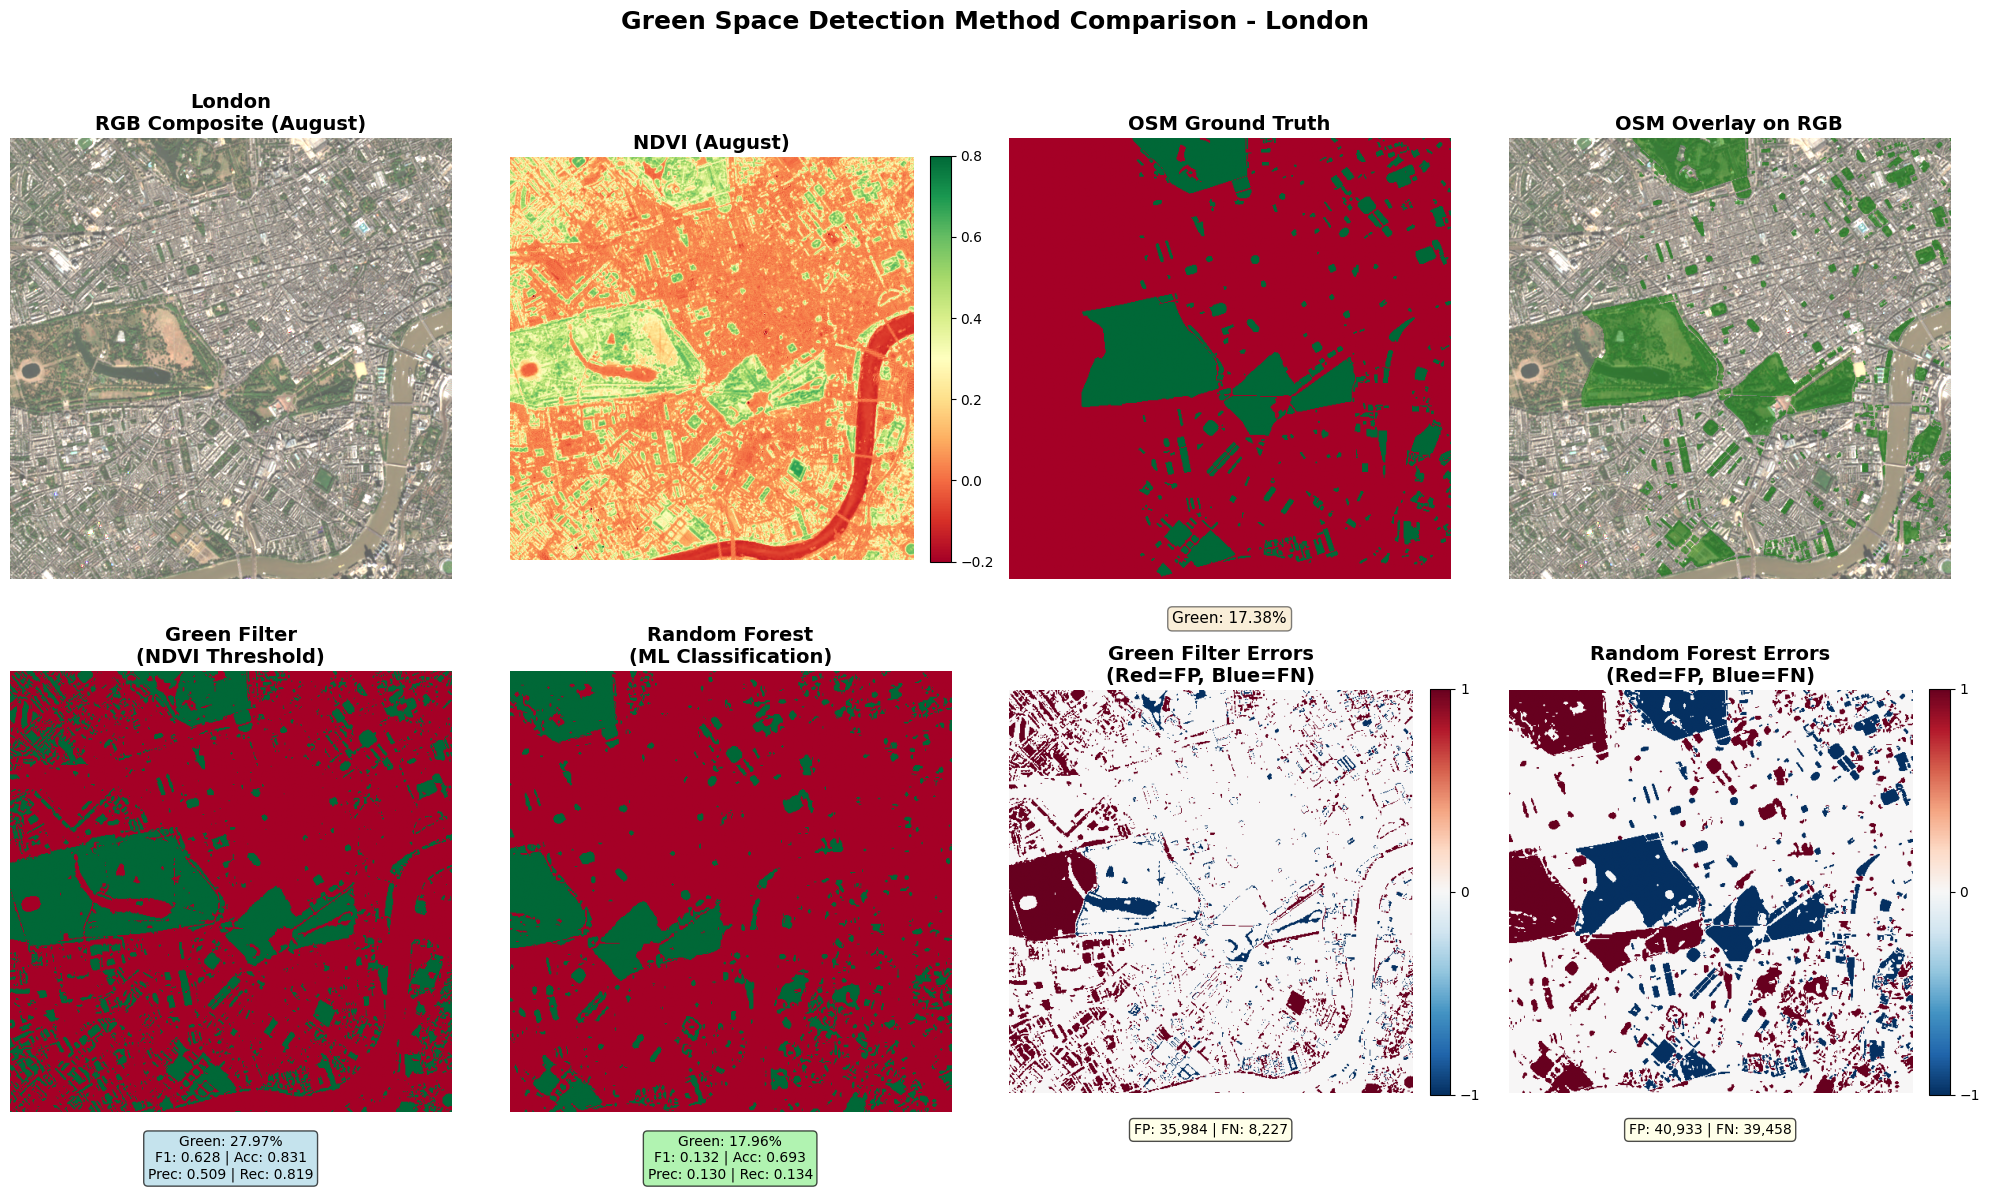

In [26]:
fig = plt.figure(figsize=(20, 12))

# Row 1: Input data
ax1 = plt.subplot(2, 4, 1)
ax1.imshow(rgb_norm)
ax1.set_title(f'{CITY}\nRGB Composite (August)', fontsize=14, fontweight='bold')
ax1.axis('off')

ax2 = plt.subplot(2, 4, 2)
im2 = ax2.imshow(ndvi_maps['August'], cmap='RdYlGn', vmin=-0.2, vmax=0.8)
ax2.set_title('NDVI (August)', fontsize=14, fontweight='bold')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

ax3 = plt.subplot(2, 4, 3)
ax3.imshow(osm_labels, cmap='RdYlGn', vmin=0, vmax=1)
ax3.set_title('OSM Ground Truth', fontsize=14, fontweight='bold')
ax3.axis('off')
ax3.text(0.5, -0.1, f"Green: {osm_metrics['green_pct']:.2f}%",
         transform=ax3.transAxes, ha='center', fontsize=11,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax4 = plt.subplot(2, 4, 4)
overlay = rgb_norm.copy()
green_mask = osm_labels == 1
overlay[green_mask] = overlay[green_mask] * 0.5 + np.array([0, 0.5, 0]) * 0.5
ax4.imshow(overlay)
ax4.set_title('OSM Overlay on RGB', fontsize=14, fontweight='bold')
ax4.axis('off')

# Row 2: Method comparisons
ax5 = plt.subplot(2, 4, 5)
ax5.imshow(green_filter_map, cmap='RdYlGn', vmin=0, vmax=1)
ax5.set_title('Green Filter\n(NDVI Threshold)', fontsize=14, fontweight='bold')
ax5.axis('off')
metrics_text = f"Green: {gf_metrics['green_pct']:.2f}%\n"
metrics_text += f"F1: {gf_metrics['f1']:.3f} | Acc: {gf_metrics['accuracy']:.3f}\n"
metrics_text += f"Prec: {gf_metrics['precision']:.3f} | Rec: {gf_metrics['recall']:.3f}"
ax5.text(0.5, -0.15, metrics_text,
         transform=ax5.transAxes, ha='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

ax6 = plt.subplot(2, 4, 6)
if rf_prediction is not None:
    ax6.imshow(rf_prediction, cmap='RdYlGn', vmin=0, vmax=1)
    ax6.set_title('Random Forest\n(ML Classification)', fontsize=14, fontweight='bold')
    metrics_text = f"Green: {rf_metrics['green_pct']:.2f}%\n"
    metrics_text += f"F1: {rf_metrics['f1']:.3f} | Acc: {rf_metrics['accuracy']:.3f}\n"
    metrics_text += f"Prec: {rf_metrics['precision']:.3f} | Rec: {rf_metrics['recall']:.3f}"
    ax6.text(0.5, -0.15, metrics_text,
             transform=ax6.transAxes, ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
else:
    ax6.text(0.5, 0.5, 'No Random Forest\nresults available',
             transform=ax6.transAxes, ha='center', va='center', fontsize=14)
    ax6.set_title('Random Forest\n(ML Classification)', fontsize=14, fontweight='bold')
ax6.axis('off')

# Error maps
ax7 = plt.subplot(2, 4, 7)
gf_diff = green_filter_map.astype(int) - osm_labels.astype(int)
im7 = ax7.imshow(gf_diff, cmap='RdBu_r', vmin=-1, vmax=1)
ax7.set_title('Green Filter Errors\n(Red=FP, Blue=FN)', fontsize=14, fontweight='bold')
ax7.axis('off')
plt.colorbar(im7, ax=ax7, fraction=0.046, pad=0.04, ticks=[-1, 0, 1])

fp_count = np.sum(gf_diff == 1)
fn_count = np.sum(gf_diff == -1)
ax7.text(0.5, -0.1, f"FP: {fp_count:,} | FN: {fn_count:,}",
         transform=ax7.transAxes, ha='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

ax8 = plt.subplot(2, 4, 8)
if rf_prediction is not None:
    rf_diff = rf_prediction.astype(int) - osm_labels.astype(int)
    im8 = ax8.imshow(rf_diff, cmap='RdBu_r', vmin=-1, vmax=1)
    ax8.set_title('Random Forest Errors\n(Red=FP, Blue=FN)', fontsize=14, fontweight='bold')
    ax8.axis('off')
    plt.colorbar(im8, ax=ax8, fraction=0.046, pad=0.04, ticks=[-1, 0, 1])

    fp_count = np.sum(rf_diff == 1)
    fn_count = np.sum(rf_diff == -1)
    ax8.text(0.5, -0.1, f"FP: {fp_count:,} | FN: {fn_count:,}",
             transform=ax8.transAxes, ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
else:
    ax8.axis('off')

plt.suptitle(f'Green Space Detection Method Comparison - {CITY}',
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Save Comparison Figure (Optional)

In [27]:
# Uncomment to save the figure
# fig.savefig(f'{CITY}_comparison.png', dpi=300, bbox_inches='tight')
# print(f"Saved to {CITY}_comparison.png")